# Advanced Databases Project Phase 1
Academic Year: 2024/2025 <br>
Authors: Diogo Barreta 64560, Muhammed Jaabir Mohamed Zifri 64912, Josè Dalla Torre 64672

## Setup
First we need to install all the necessary packages.

In [30]:
!pip install pandas
!pip install mysql-connector-python
!pip install matplotlib
!pip install pymongo
!pip install sqlalchemy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Data visualization
Before starting to clean the data we need to load the csv as dataframe. <br>
After that we display the first rows to see the format of the data.

In [31]:
import pandas as pd
import numpy as np
n_rows = 50000
cards_df = pd.read_csv('archive/cards_data.csv',nrows=n_rows)
transactions_df = pd.read_csv('archive/transactions_data.csv',nrows=n_rows)
users_df = pd.read_csv('archive/users_data.csv',nrows=n_rows)

In [32]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [33]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [34]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


### Missing Data
After the first exploration of the data we want to see if there are any missing values. <br>
To have a better understanding of the distribution of the values we use a countplot for every column of the dataframe.

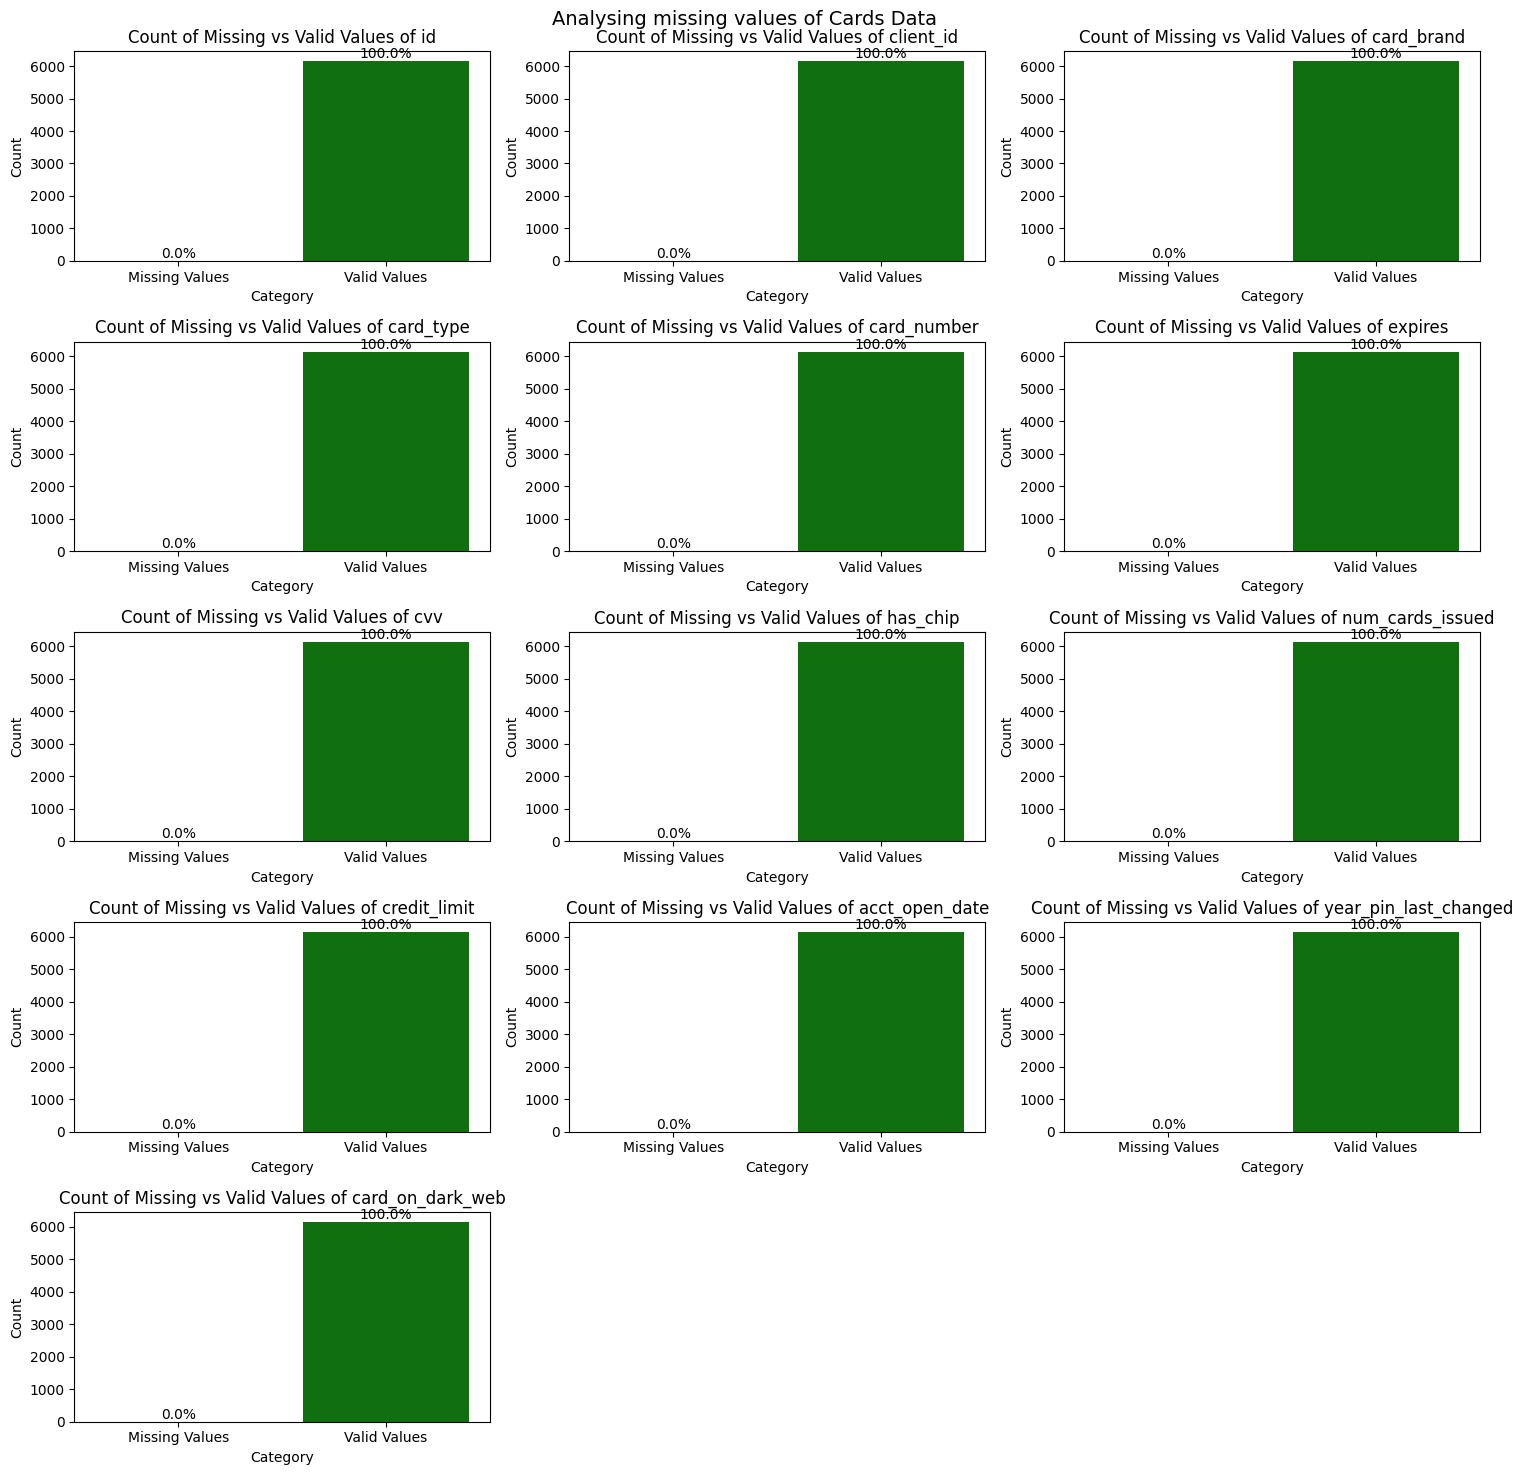

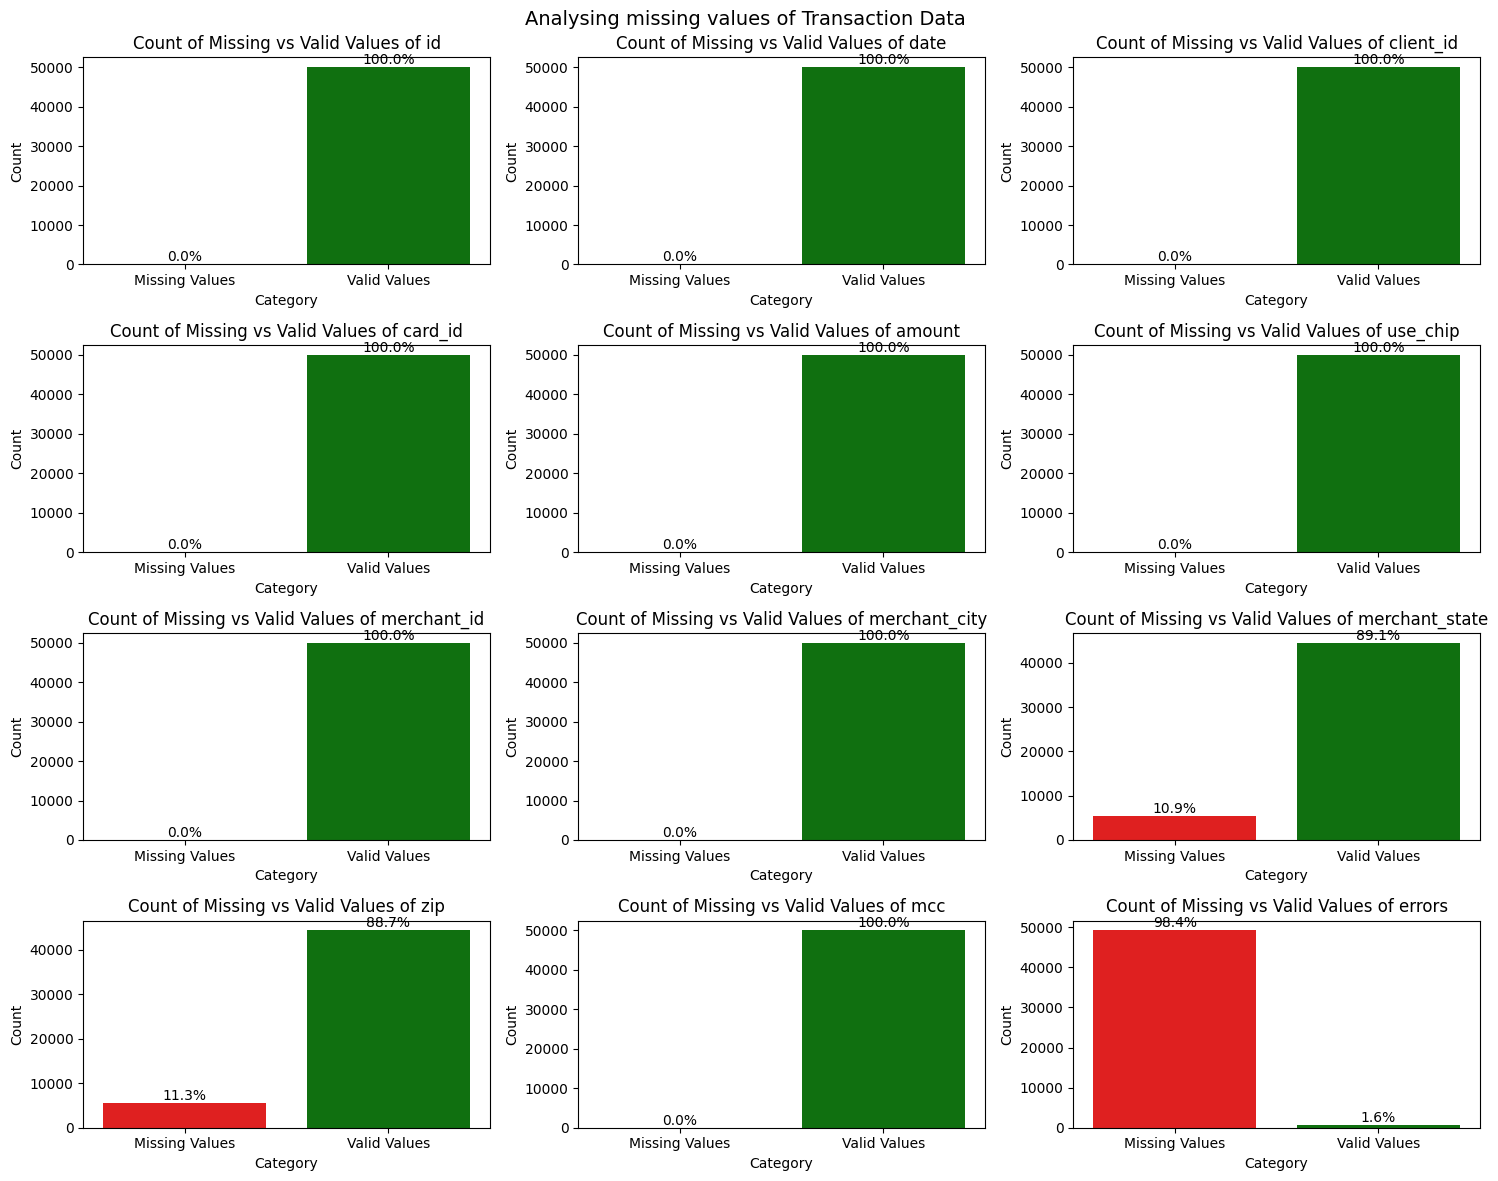

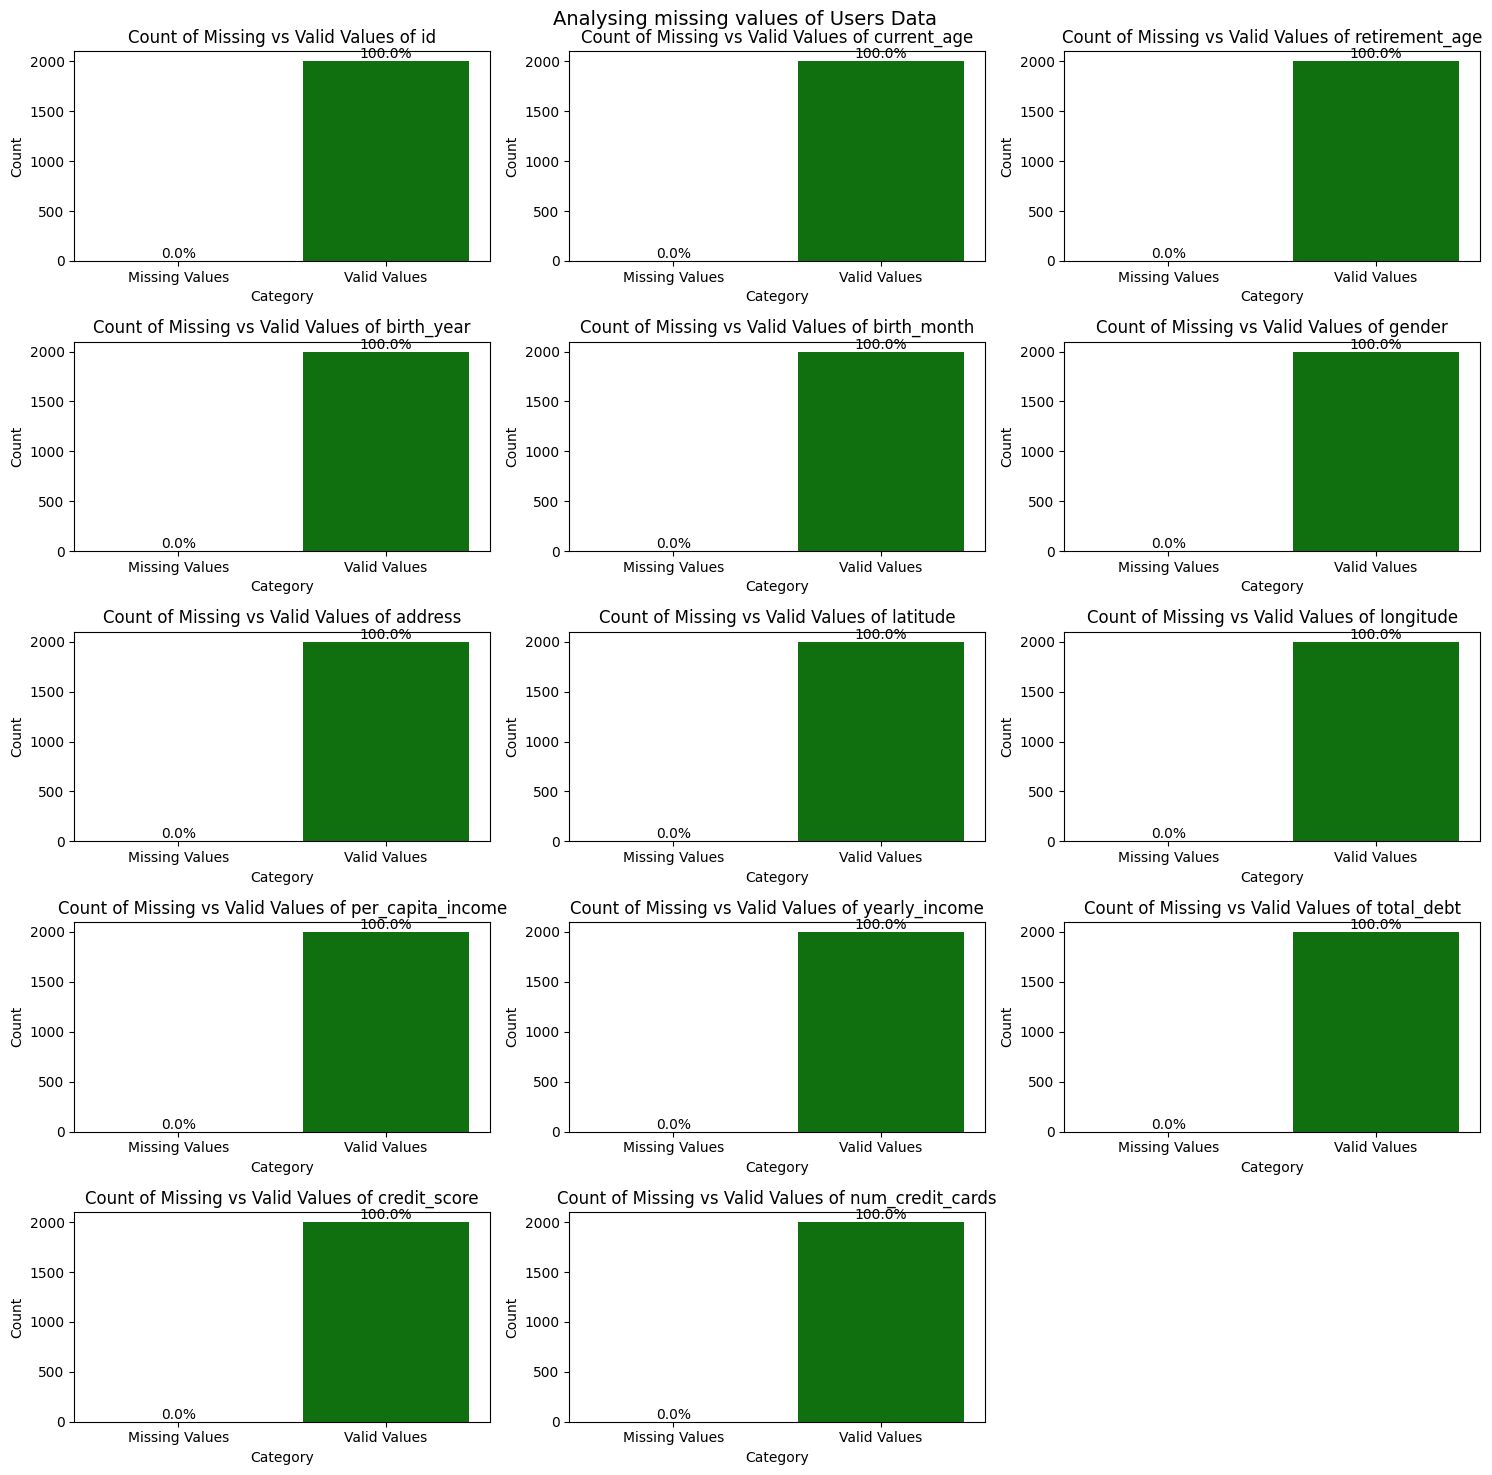

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def create_plot(df: pd.DataFrame, df_name:str)-> None:
    n_cols = 3
    n_rows = math.ceil(len(df.columns) / n_cols)
    plt.figure(figsize=(15, n_rows * 3))
    for i,column in enumerate(df.columns,1):
        # Count missing and valid values
        total = len(df[column])
        missing_count = df[column].isna().sum()
        valid_count = df[column].notna().sum()

        # Prepare data for plotting
        plot_data = pd.DataFrame({
            'Category': ['Missing Values', 'Valid Values'],
            'Count': [missing_count, valid_count]
        })
        # Create the 
        plt.suptitle(f"Analysing missing values of {df_name}", fontsize=14)
        # Create the countplot
        ax = plt.subplot(n_rows,n_cols,i)
        sns.barplot(data=plot_data, x='Category', y='Count',hue='Category', palette=['red', 'green'])
        plt.title(f"Count of Missing vs Valid Values of {column}")
        plt.ylabel('Count')
        plt.xlabel('Category')
        for c in ax.containers:
            ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    plt.tight_layout()
    plt.show()

create_plot(cards_df, "Cards Data")
create_plot(transactions_df, "Transaction Data")
create_plot(users_df, "Users Data")

## Data Cleaning
We can see that only the transactions data has missing values. <br>
First we remove from the users data the unnecessary string like the dollar sign, then we convert all the column to the same value based on data present.

In [36]:
remove_currency = lambda x: float(x.replace("$","").strip())
users_df["per_capita_income"] = users_df["per_capita_income"].apply(remove_currency)
users_df["yearly_income"] = users_df["yearly_income"].apply(remove_currency)
users_df["total_debt"] = users_df["total_debt"].apply(remove_currency)
users_df["gender"] = users_df["gender"].astype("string")
users_df["address"] = users_df["address"].astype("string")
users_df.dtypes

id                            int64
current_age                   int64
retirement_age                int64
birth_year                    int64
birth_month                   int64
gender               string[python]
address              string[python]
latitude                    float64
longitude                   float64
per_capita_income           float64
yearly_income               float64
total_debt                  float64
credit_score                  int64
num_credit_cards              int64
dtype: object

We apply the same logic to the cards dataframe. <br>
We decided to convert from "YES" or "NO" to boolean value to simplify the insertion in the database later. <br>
Also we decided to convert the date to the Datetime of pandas <br>

In [37]:
cards_df["credit_limit"] = cards_df["credit_limit"].apply(remove_currency)
cards_df["has_chip"] = cards_df["has_chip"].replace({"YES": True, "NO": False})
cards_df["card_on_dark_web"] = cards_df["card_on_dark_web"].replace({"Yes": True, "No": False})
cards_df["card_brand"] = cards_df["card_brand"].astype("string")
cards_df["card_type"] = cards_df["card_type"].astype("string")
cards_df["card_number"] = cards_df["card_number"].astype("string")
cards_df["expires"] = pd.to_datetime(cards_df["expires"])
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"])
cards_df.dtypes

/tmp/ipykernel_99238/1931433102.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df["has_chip"] = cards_df["has_chip"].replace({"YES": True, "NO": False})
/tmp/ipykernel_99238/1931433102.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df["card_on_dark_web"] = cards_df["card_on_dark_web"].replace({"Yes": True, "No": False})
/tmp/ipykernel_99238/1931433102.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expec

id                                int64
client_id                         int64
card_brand               string[python]
card_type                string[python]
card_number              string[python]
expires                  datetime64[ns]
cvv                               int64
has_chip                           bool
num_cards_issued                  int64
credit_limit                    float64
acct_open_date           datetime64[ns]
year_pin_last_changed             int64
card_on_dark_web                   bool
dtype: object

Now it's time to clean the dataframe that contains the data about the transactions. <br>
We decided to fill the missing data of the **merchant_state** column as "Unkown" to prevent missing values. <br>
We decided to fill the missing data of the **zip** column as "0" to prevent missing values. <br>
We decided to fill the missing data of the **errors** column as "No Errors" to prevent missing values. <br>

In [38]:
transactions_df["amount"] = transactions_df["amount"].apply(remove_currency)
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
transactions_df["use_chip"] = transactions_df["use_chip"].astype("string")
transactions_df["merchant_city"] = transactions_df["merchant_city"].astype("string")
transactions_df["merchant_state"] = transactions_df["merchant_state"].astype("string")
transactions_df["merchant_state"] = transactions_df["merchant_state"].fillna('Unknown')
transactions_df['zip'] = transactions_df["zip"].fillna('0')
transactions_df['zip'] = transactions_df["zip"].astype(np.float64)
transactions_df["errors"] = transactions_df["errors"].astype("string")
transactions_df["errors"] = transactions_df["errors"].fillna("No Errors")
transactions_df.dtypes

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip          string[python]
merchant_id                int64
merchant_city     string[python]
merchant_state    string[python]
zip                      float64
mcc                        int64
errors            string[python]
dtype: object

## MySQL
This section is dedicated to the definition of the tables, insertion and queries of the MySQL database.

### Setup
Since the components of the group are coding on different machine we decided to use a file called ".env" to store the configurations for the databases. <br>
The code to load the configuration is reported below

In [39]:
import dotenv
import os
import mysql.connector
## database initialization
dotenv.load_dotenv()
database_name = 'group25'

MYSQL_CONFIG = {
    'username': os.environ['mysql_username'],
    'password': os.environ['mysql_password'],
    'host'    : os.environ['mysql_hostname'],
    'database_name' : database_name
}
# Create Connection
connection = mysql.connector.connect(
  host=MYSQL_CONFIG["host"],
  user=MYSQL_CONFIG["username"],
  password=MYSQL_CONFIG["password"]
)
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306/{database_name}"

### Insertion into MySQL
Before we delete the database and the tables to make sure that we can create them correctly

In [40]:
cursor = connection.cursor()
cursor.execute(f"DROP DATABASE IF EXISTS {database_name}")
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
cursor.execute(f"USE {database_name}")


cursor.execute(f"DROP TABLE IF EXISTS users")
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
              id INT PRIMARY KEY,
              current_age INT,
              retirement_age INT,
              birth_year INT,
              birth_month INT,
              gender VARCHAR(255),
              address VARCHAR(255),
              latitude DECIMAL,
              longitude DECIMAL,
              per_capita_income DECIMAL,
              yearly_income DECIMAL,
              total_debt DECIMAL,
              credit_score INT,
              num_credit_cards INT
);
""")

cursor.execute(f"DROP TABLE IF EXISTS cards")
cursor.execute("""
CREATE TABLE IF NOT EXISTS cards (
      id INT PRIMARY KEY,
      client_id INT,
      card_brand VARCHAR(255),
      card_type VARCHAR(255),
      card_number VARCHAR(255),
      expires DATETIME,
      cvv INT,
      has_chip BOOLEAN,
      num_cards_issued INT,
      credit_limit DECIMAL,
      acct_open_date DATETIME,
      year_pin_last_changed INT,
      card_on_dark_web BOOLEAN,
      FOREIGN KEY (client_id) REFERENCES users(id)
);
""")

cursor.execute(f"DROP TABLE IF EXISTS transactions")
cursor.execute("""
CREATE TABLE IF NOT EXISTS transactions (
    id INT PRIMARY KEY,
    date DATETIME,
    client_id INT,
    card_id INT,
    amount DECIMAL,
    use_chip VARCHAR(255),
    merchant_id INT,
    merchant_city VARCHAR(255),
    merchant_state VARCHAR(255),
    zip DECIMAL,
    mcc INT,
    errors VARCHAR(255),
    FOREIGN KEY (client_id) REFERENCES users(id),
    FOREIGN KEY (card_id) REFERENCES cards(id)
);
""")
 

connection.commit()
cursor.execute("SHOW TABLES")
for table in cursor:
    print(table)

('cards',)
('transactions',)
('users',)


### Populate the Database
After that we populate the database as seen in class. <br>
We keep track of the time to compare later with the mongodb

In [41]:
from sqlalchemy import create_engine, text
import time
mysql_times = []
engine = create_engine(db_url)
start_time = time.time()
users_df.to_sql('users', con=engine, if_exists='append', index=False, method='multi')
cards_df.to_sql('cards', con=engine, if_exists='append', index=False, method='multi')
transactions_df.to_sql('transactions', con=engine, if_exists='append', index=False, method='multi')
end_time = time.time()
mysql_times.append(end_time - start_time)
print("Data inserted into MySQL")

Data inserted into MySQL


### Queries
Now we define the queries with a short description to help the reader

In [42]:
queries = []

In [43]:
q1 = {
    "description":"Select users with a credit score greater than 750.",
    "query" : "SELECT id, current_age, yearly_income, credit_score FROM users WHERE credit_score > 750;"
    }
queries.append(q1)

In [44]:
q2 ={
    "description" :"Select all transactions where errors occurred.",
    "query" : "SELECT id, date, card_id, amount, errors FROM transactions WHERE errors != 'No Errors';"
}
queries.append(q2)

In [45]:
q3 ={
    "description": "Calculate the total transaction amount per state for female users.",
     "query" : """SELECT U.gender, T.merchant_state, SUM(T.amount) AS total_spent 
     FROM transactions T JOIN users U ON T.client_id = U.id 
     WHERE U.gender = 'Female' GROUP BY T.merchant_state;"""
}
queries.append(q3)

In [46]:
q4 = {
    "description": "Find all cards flagged as on_dark_web that were used in transactions exceeding $1,000.",
    "query" : """SELECT C.card_number, C.card_brand, T.amount, T.date
               FROM transactions T
               JOIN cards C ON T.card_id = C.id
               WHERE C.card_on_dark_web = 1 AND T.amount > 1000;"""
}
queries.append(q4)

Now we esecute them and we track the times to evaluate the performance later.

In [47]:
with engine.connect() as conn:
    for q in queries:
        start_time = time.time()
        if "Select users with a credit score greater than 750." in q["description"]:
            result = conn.execute(text(q["query"]))
        elif "Select all transactions where errors occurred." in q["description"]:
            result = conn.execute(text(q["query"]))
        elif "Find all cards flagged as on_dark_web that were used in transactions exceeding $1,000." in q["description"]:
            result = conn.execute(text(q["query"]))
        else:
            result = conn.execute(text(q["query"]))
        results =  result.fetchall()
        end_time = time.time()
        mysql_times.append(end_time - start_time)
        print(f"{q['description']}: {len(results)} results found in {end_time - start_time:.4f} seconds")

Select users with a credit score greater than 750.: 524 results found in 0.0242 seconds
Select all transactions where errors occurred.: 800 results found in 0.0969 seconds
Calculate the total transaction amount per state for female users.: 59 results found in 0.2312 seconds
Find all cards flagged as on_dark_web that were used in transactions exceeding $1,000.: 0 results found in 0.0086 seconds


## MongoDB

As seen before we utilize the configuration file to load the data

In [ ]:
from pymongo import MongoClient, ASCENDING, DESCENDING 
MONGO_DB_CONFIG = {
    'username': os.environ['mongo_username'],
    'password': os.environ['mongo_password'],
    'hostname' : os.environ['mongo_hostname'],
    'appName' : os.environ['mongo_appName'],
    'port'    : os.environ['mongo_port']
}


Then we connect to the database and we drop the collections

In [49]:
uri = f'mongodb://{MONGO_DB_CONFIG["hostname"]}:{MONGO_DB_CONFIG["port"]}'
client = MongoClient(uri)
db = client[database_name]
db['users'].drop()
db['cards'].drop()
db['transactions'].drop()
print("Collections dropped")

Collections dropped


Now we define the collections with the validator, we use a similar structure to the MySQL schema

In [50]:
#Users collection
db.create_collection("users", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": ["id", "current_age", "retirement_age", "birth_year", "birth_month", "gender", "address", "latitude", "longitude", "per_capita_income", "yearly_income", "total_debt", "credit_score", "num_credit_cards"],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "current_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "retirement_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "birth_year": {
        "bsonType": "int",
        "description": "Must be an integer representing the year of birth and is required."
      },
      "birth_month": {
        "bsonType": "int",
        "description": "Must be an integer representing the month of birth and is required."
      },
      "gender": {
        "bsonType": "string",
        "enum": ["Male", "Female", "Other"],
        "description": "Must be a string and one of the predefined values."
      },
      "address": {
        "bsonType": "string",
        "description": "Must be a string representing the address and is required."
      },
      "latitude": {
        "bsonType": "double",
        "description": "Must be a float representing the latitude coordinate and is required."
      },
      "longitude": {
        "bsonType": "double",
        "description": "Must be a float representing the longitude coordinate and is required."
      },
      "per_capita_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "yearly_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "total_debt": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "credit_score": {
        "bsonType": "int",
        "description": "Must be an integer representing the credit score and is required."
      },
      "num_credit_cards": {
        "bsonType": "int",
        "description": "Must be an integer representing the number of credit cards and is required."
      }
    }
  }
}
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'users')

In [51]:
db.create_collection("cards", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": [
      "id",
      "client_id",
      "card_brand",
      "card_type",
      "card_number",
      "expires",
      "cvv",
      "has_chip",
      "num_cards_issued",
      "credit_limit",
      "acct_open_date",
      "year_pin_last_changed",
      "card_on_dark_web"
    ],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "client_id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_brand": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_type": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_number": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "expires": {
        "bsonType": "date",
        "description": "must be a date"
      },
      "cvv": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "has_chip": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      },
      "num_cards_issued": {
        "bsonType": "int",
        "description": "must be an integer greater than 0"
      },
      "credit_limit": {
        "bsonType": "double",
        "description": "must be a float and is required"
      },
      "acct_open_date": {
        "bsonType": "date",
        "description": "must be a date"
      },
      "year_pin_last_changed": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_on_dark_web": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      }
    }
  }
}
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'cards')

In [52]:
#Transactions collection
db.create_collection("transactions", validator = {
    "$jsonSchema": {
      "bsonType": "object",
      "required": ["id", "date", "client_id", "card_id", "amount", "merchant_city", "merchant_state","errors"],
      "properties": {
        "id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "date": {
          "bsonType": "date",
          "description": "Must be a date and is required"
        },
        "client_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "card_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "amount": {
          "bsonType": "double",
          "description": "Must be a float representing a monetary value and is required."
        },
        "use_chip": {
          "bsonType": "string",
          "description": "Must be a string indicating the transaction type if provided."
        },
        "merchant_id": {
          "bsonType": "int",
          "description": "Must be an integer if provided."
        },
        "merchant_city": {
          "bsonType": "string",
          "description": "Must be a string representing a city name and is required."
        },
        "merchant_state": {
          "bsonType": "string",
          "description": "Must be a string representing a state code and is required."
        },
        "zip": {
          "bsonType": "double",
          "description": "Must be a float representing a ZIP code if provided."
        },
        "mcc": {
          "bsonType": "int",
          "description": "Must be an integer representing a Merchant Category Code if provided."
        },
        "errors": {
          "bsonType": "string",
          "description": "Must be a string and is required."
        }
      }
    }
  }
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'transactions')

In [53]:
users_collection = db['users']
cards_collection = db['cards']
transactions_collection = db['transactions']

Now we insert into the mongodb and we keep the times, similar to the section of MySQL

In [54]:
### inserting the documents to the mongo db 
mongo_times = []
def insert_to_mongo_db(df: pd.DataFrame, c) -> None:
    collection = c
    initial_count = collection.count_documents({})
    print(f"# documents: {initial_count}.") 
    try:
        data_dict = df.to_dict(orient="records")
        result = collection.insert_many(data_dict, ordered=False)
        valid_count = collection.count_documents({}) - initial_count
        print(f"{valid_count} documents inserted.")

    except Exception as e:
        attempted_count = len(data_dict)
        valid_count = collection.count_documents({}) - initial_count
        print(f"{valid_count} documents inserted")
        print(f"{attempted_count - valid_count} documents failed to insert")


    print(f"# documents: {collection.count_documents({})}") 

start_time = time.time()
insert_to_mongo_db(users_df,users_collection)
insert_to_mongo_db(cards_df,cards_collection)
insert_to_mongo_db(transactions_df,transactions_collection)
end_time = time.time()
mongo_times.append(end_time - start_time)

# documents: 0.
2000 documents inserted.
# documents: 2000
# documents: 0.
6146 documents inserted.
# documents: 6146
# documents: 0.
50000 documents inserted.
# documents: 50000


Then we define the queries and execute them

In [ ]:
mongo_q1 = {"credit_score": {"$gt": 750}}

In [ ]:
mongo_q2 = ({"errors": {"$ne" : "No Errors"}})

In [ ]:
mongo_q3 = [
    {
        "$match": {
            "gender": "Female"
        }
    },
    {
        "$lookup": {
            "from": "transactions",  
            "localField": "id",  
            "foreignField": "client_id",  
            "as": "user_transactions"  
        }
    },
    {
        "$unwind": "$user_transactions"
    },
    {
        "$group": {
            "_id": "$user_transactions.merchant_state",  
            "total_amount": {
                "$sum": {
                    "$toDouble": "$user_transactions.amount"  
                }
            }
        }
    },
    {
        "$sort": {
            "total_amount": -1
        }
    },
    {
        "$limit": 100
        }
        ]

In [ ]:
mongo_q4 = [
    {
        "$match": {
            "card_on_dark_web": True # for now using No because there are no Yes 
        }
    },
    {
        "$lookup": {
            "from": "transactions",  
            "localField": "id",  
            "foreignField": "card_id",  
            "as": "transactions"  
        }
    },
    {
        "$unwind": "$transactions"
    },
    {
        "$addFields": {
            "transactions.amount": {
                "$toDouble": "$transactions.amount"  
            }
        }
    },
    {
        "$match": {
            "transactions.amount": {"$gt": 1000}
        }
    }
        ]

In [ ]:
for q in queries:
    start_time = time.time()
    
    if "Select users with a credit score greater than 750." in q["description"]:
        query = mongo_q1
        result = users_collection.find(query)

    elif "Select all transactions where errors occurred." in q["description"]:
        query = mongo_q2
        result = transactions_collection.find(query)
    elif "Calculate the total transaction amount per state for female users." in q["description"]:
        query = mongo_q3
        result = users_collection.aggregate(query)
    else:
        query = mongo_q4
        result = users_collection.aggregate(query)
        

    end_time = time.time()
 
    list_result = list(result)
    mongo_times.append(end_time - start_time)
    print(f"{q['description']}: {len(list_result)} found in {end_time - start_time:.4f} seconds")
client.close()

Select users with a credit score greater than 750.: 524 found in 0.0001 seconds
Select all transactions where errors occurred.: 800 found in 0.0001 seconds
Calculate the total transaction amount per state for female users.: 59 found in 30.2157 seconds
Find all cards flagged as on_dark_web that were used in transactions exceeding $1,000.: 0 found in 0.0020 seconds


## Comparison
Now we want to evaluate the performance of MongoDB vs MySQL <br>
First we define a dataframe with the two lists that contain the times then we plot the result highlighting the differences in the execution time. <br>

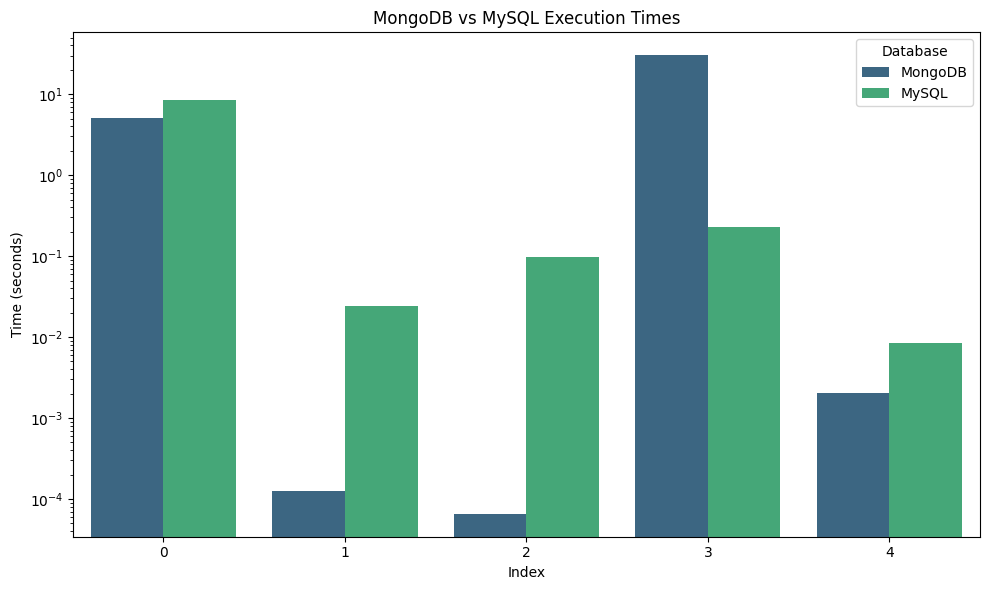

In [56]:
# Combine data into a DataFrame
data = pd.DataFrame({
    'Index': range(len(mongo_times)),
    'MongoDB': mongo_times,
    'MySQL': mysql_times
})
# Melt the DataFrame to plot later
melted_data = pd.melt(data, id_vars=['Index'], var_name='Database', value_name='Time')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='Index', y='Time', hue='Database', palette='viridis')
plt.title('MongoDB vs MySQL Execution Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Index')
plt.yscale('log')  # Use log scale for better visualization of the range
plt.legend(title='Database')
plt.tight_layout()
plt.show()

The first index is related to the population of the database. <br>
The others four are related to the queries. <br>
As we can see MongoDB has a better performance overall expect in third query that has the worst time. It needs 28 second to execute the query while MySQL takes less than half of a second.

## Phase 2


### MySQL

In [57]:
mysql_index_times = []

In [58]:
cursor = connection.cursor()
cursor.execute("CREATE INDEX gender_index ON users (gender);")
cursor.execute("CREATE INDEX merchant_state_index ON transactions (merchant_state);")
print("\nCompound index on 'gender' and 'merchant_state' created.")
query = q3["query"]
# Query with the compound index
print("\nQuerying with compound index (gender = 'Female' and merchant_state):")
start_time = time.time()
cursor.execute(query)
results = cursor.fetchall()
index_time = time.time() - start_time
mysql_index_times.append(index_time)
print(f"Number of results: {len(results)}")
print(f"Query time with index: {index_time:.4f} seconds")
cursor.execute(f"EXPLAIN ANALYZE {query}")
explain_result_after = cursor.fetchall()
print("Explain output with compound index:")
for row in explain_result_after:
    print(row)


sqlShowIndexes = "show index from users"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)
sqlShowIndexes = "show index from transactions"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)

cursor.execute("DROP INDEX gender_index ON users;")
cursor.execute("DROP INDEX merchant_state_index ON transactions;")


Compound index on 'gender' and 'merchant_state' created.

Querying with compound index (gender = 'Female' and merchant_state):
Number of results: 59
Query time with index: 0.1286 seconds
Explain output with compound index:
("-> Table scan on <temporary>  (actual time=177..177 rows=59 loops=1)\n    -> Aggregate using temporary table  (actual time=177..177 rows=59 loops=1)\n        -> Nested loop inner join  (cost=22502 rows=25302) (actual time=0.0492..143 rows=25493 loops=1)\n            -> Filter: (T.client_id is not null)  (cost=5069 rows=49808) (actual time=0.0362..33.9 rows=50000 loops=1)\n                -> Table scan on T  (cost=5069 rows=49808) (actual time=0.0347..28.8 rows=50000 loops=1)\n            -> Filter: (U.gender = 'Female')  (cost=0.25 rows=0.508) (actual time=0.00199..0.00204 rows=0.51 loops=50000)\n                -> Single-row index lookup on U using PRIMARY (id=T.client_id)  (cost=0.25 rows=1) (actual time=0.00167..0.0017 rows=1 loops=50000)\n",)
[('users', 0, 'PR

In [59]:
cursor.execute("CREATE INDEX card_on_dark_web_index ON cards (card_on_dark_web);")
cursor.execute("CREATE INDEX amount_index ON transactions (amount);")
print("\nCompound index on 'card_on_dark_web' and 'amount' created.")
query = q4["query"]
# Query with the compound index
print("\nQuerying with compound index (card_on_dark_web = '1' and amount >1000):")
start_time = time.time()
cursor.execute(query)
results = cursor.fetchall()
index_time = time.time() - start_time
mysql_index_times.append(index_time)
print(f"Number of results: {len(results)}")
print(f"Query time with index: {index_time:.4f} seconds")
cursor.execute(f"EXPLAIN ANALYZE {query}")
explain_result_after = cursor.fetchall()
print("Explain output with compound index:")
for row in explain_result_after:
    print(row)


sqlShowIndexes = "show index from cards"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)
sqlShowIndexes = "show index from transactions"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)

cursor.execute("DROP INDEX card_on_dark_web_index ON cards;")
cursor.execute("DROP INDEX amount_index ON transactions;")

cursor.close()
connection.close()


Compound index on 'card_on_dark_web' and 'amount' created.

Querying with compound index (card_on_dark_web = '1' and amount >1000):
Number of results: 0
Query time with index: 0.0033 seconds
Explain output with compound index:
('-> Nested loop inner join  (cost=7.29 rows=0.05) (actual time=0.022..0.022 rows=0 loops=1)\n    -> Index lookup on C using card_on_dark_web_index (card_on_dark_web=1)  (cost=0.35 rows=1) (actual time=0.0198..0.0198 rows=0 loops=1)\n    -> Filter: (T.amount > 1000)  (cost=4.96 rows=0.05) (never executed)\n        -> Index lookup on T using card_id (card_id=C.id)  (cost=4.96 rows=19.8) (never executed)\n',)
[('cards', 0, 'PRIMARY', 1, 'id', 'A', 5867, None, None, '', 'BTREE', '', '', 'YES', None), ('cards', 1, 'client_id', 1, 'client_id', 'A', 2000, None, None, 'YES', 'BTREE', '', '', 'YES', None), ('cards', 1, 'card_on_dark_web_index', 1, 'card_on_dark_web', 'A', 1, None, None, 'YES', 'BTREE', '', '', 'YES', None)]
[('transactions', 0, 'PRIMARY', 1, 'id', 'A', 

### MongoDB

In [61]:
def indexes_information(collection):
    indexes_info = collection.index_information()
    print(indexes_info)
indexes_information(users_collection)
indexes_information(cards_collection)
indexes_information(transactions_collection)

{'_id_': {'v': 2, 'key': [('_id', 1)]}}
{'_id_': {'v': 2, 'key': [('_id', 1)]}}
{'_id_': {'v': 2, 'key': [('_id', 1)]}}


In [ ]:
import pprint
# Create an index on 'gender'
users_collection.create_index([("gender", ASCENDING)])
print("\nIndex on 'gender' created.")
print(users_collection.index_information())

# Query with the index
print("\nQuerying with index:")
results = list(users_collection.find(query))
print(f"Number of results: {len(results)}")
print("\nTime in millis:")
explain_output = users_collection.find(query).explain()
pprint.pprint(explain_output["executionStats"]["executionTimeMillis"])

# Drop index
users_collection.drop_index('species_1')